In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import ftfy

In [111]:
%matplotlib inline
plt.style.use('ggplot')

In [3]:
df = pd.read_pickle("/data/rali7/Tmp/solimanz/LBJ/dataset/dataframe.pkl")

In [4]:
df["transformed"] = df.function.str.lower()

In [5]:
def fmtcols(mylist, cols):
    maxwidth = max(map(lambda x: len(x), mylist))
    justifyList = list(map(lambda x: x.ljust(maxwidth), mylist))
    lines = (' '.join(justifyList[i:i+cols]) for i in range(0,len(justifyList),cols))
    return "\n".join(lines)

def write_job_titles(df):
    job_titles = df.transformed.value_counts().index.values
    with open('../job_titles.txt', 'w') as f:
        for j in job_titles:
            f.write(f"{j}\n")

In [6]:
job_titles = df.transformed.value_counts().index.values

In [93]:
len(job_titles)

4524015

In [67]:
bad = [s for s in job_titles if re.findall(r'[^\x00-\x7F]+', s)]

In [68]:
bad_ids = df[df.transformed.isin(bad)]._id.unique()

In [71]:
df = df[~df._id.isin(bad_ids)]

In [72]:
df._id.nunique()

4076918

In [73]:
df.to_pickle("/data/rali7/Tmp/solimanz/LBJ/dataset/dataframe.pkl")

In [96]:
bad = [s for s in job_titles if re.findall(r'^[^a-z]+$', s)]

In [97]:
len(bad)

28

In [98]:
bad_ids = df[df.transformed.isin(bad)]._id.unique()

In [99]:
len(bad_ids)

54

In [100]:
df = df[~df._id.isin(bad_ids)]
df._id.nunique()

4073425

In [101]:
df.to_pickle("/data/rali7/Tmp/solimanz/LBJ/dataset/dataframe.pkl")

In [102]:
job_titles = df.transformed.value_counts().index.values

In [103]:
with open('../job_titles.txt', 'w') as f:
    for j in job_titles:
        f.write(f"{j}\n")

In [7]:
df._id.nunique()

4073425

In [8]:
len(job_titles)

4686647

# Apply RegEx Transformations

## Older RegEx

In [18]:
# Remove URLs and/or emails from job titles
pattrn = re.compile(r"[\S]+\.(ca|com|org|fr|gov|net)")
df["transformed"] = df["transformed"].str.replace(pattrn, "")

# Replace .NET by dotnet to eliminate complications when removing periods
df["transformed"] = df["transformed"].str.replace(".net\b", "dotnet")

# Replace periods between word by a space
pattrn = re.compile(r"\.(?=[\w]{2})")
df["transformed"] = df["transformed"].str.replace(pattrn, " ")

# Replace periods in acronyms by empty string
df["transformed"] = df["transformed"].str.replace(".", "")

# Remove parens character
df["transformed"] = df["transformed"].str.replace(re.compile(r"\(.*\)"), "")

df["transformed"] = df["transformed"].str.replace(re.compile(r"co(?!\w)(\s)*-?(\s)*"), "co ")
df["transformed"] = df["transformed"].str.replace(re.compile(r"\bcofounder\b"), "co founder")
df["transformed"] = df["transformed"].str.replace(re.compile(r"\bcoowner\b"), "co owner")

#df["transformed"] = df["transformed"].str.replace(re.compile(r"co(?!\w)(\s)*-?(\s)*"), "co_")

In [19]:
transforms = [    
    # senior/junior
    (re.compile(r'\bsr\b'), 'senior'),
    (re.compile(r'\bjr\b'), 'junior'),
    # IT
    (re.compile(r'\bit\b'), 'information technology'),
    # C*O
    (re.compile(r'\bceo\b'), 'chief executive officer'),
    (re.compile(r'\bcoo\b'), 'chief operating officer'),
    (re.compile(r'\bcto\b'), 'chief technology officer'),
    (re.compile(r'\bcfo\b'), 'chief finance officer'),
    (re.compile(r'\bchief financial officer\b'), 'chief finance officer'),
    (re.compile(r'\bchief operations officer\b'), 'chief operating officer'),
    # VP
    (re.compile(r'\bvp\b'), 'vice president'),
    (re.compile(r'\bvice-president\b'), 'vice president'),
    #technician vs tech
    (re.compile(r'\btech\b'), 'technician'),
    #coop
    (re.compile(r'\bco[-|\s]op\b'), 'coop'),
    #addon
    (re.compile(r'\badd[-|\s]on\b'), 'addon'),
    # Nurses
    (re.compile(r'\brn\b'), 'registered nurse'),
    (re.compile(r'\brpn\b'), 'registered practical nurse'),
    #T.A.
    (re.compile(r"\bta\b"), "teaching assistant"),
    (re.compile(r"\bteacher assistant\b"), "teaching assistant"),
    (re.compile(r"\bteacher's assistant\b"), "teaching assistant"),
    (re.compile(r"\bteacher's assitant\b"), "teaching assistant"),
    
    (re.compile(r"\bra\b"), "research assistant"),
    # HR
    (re.compile(r'\bhr\b'), 'human resources'),
    # Customer service reps
    (re.compile(r'\bcsr\b'), 'customer service representative'),
    # qa / qc
    (re.compile(r'\bqa\b'), 'quality assurance'),
    (re.compile(r'\bqc\b'), 'quality control'),
    # database administrator
    (re.compile(r'\bdba\b'), 'database administrator'),
    (re.compile(r'\bdatabase admin\b'), 'database administrator'),
    (re.compile(r'\bdb admin\b'), 'database administrator'),
    # financial service representative
    (re.compile(r'\bfsr\b'), 'financial service representative'),
    # Misspellings
    (re.compile(r'\bfreelance\b'), 'freelancer'),
    (re.compile(r'\bdesiginer\b'), 'designer'),
    (re.compile(r'\bbiomed\b'), 'biomedical'),
    (re.compile(r'\bgoverenment\b'), 'government'),
    (re.compile(r'\bmachanic\b'), 'mechanic'),
    (re.compile(r'\bbusiness owner\b'), 'owner'),
    (re.compile(r'\br(\s)*&(\s)*d\b'), 'research development'),
    (re.compile(r'\br and d\b'), 'research development'),
    (re.compile(r'research/development'), 'research development'),
    (re.compile(r'\beditor-in-chief\b'), 'editor_in_chief'),
    #eit => engineer in training
    (re.compile(r'\beit\b'), 'engineer in training'),
    #ESL
    (re.compile(r'\besl$'), 'english as a second language instructor'),
    (re.compile(r'\besl instructor\b'), 'english as a second language instructor'),
    (re.compile(r'\besl teacher\b'), 'english as a second language instructor'),
    (re.compile(r'\benglish as a second language^'), 'english as a second language instructor'),
    (re.compile(r'\benglish as a second language teacher\b'), 'english as a second language instructor'),
    (re.compile(r'\besl instructor\b'), 'english as a second language instructor'),
    
    (re.compile(r"\binternship\b"), "intern"),
    (re.compile(r"\bsummer intern\b"), "intern"),
    
    (re.compile(r"\bis\b"), "information systems"),
    (re.compile(r"\bgis\b"), "geographic information system"),
    (re.compile(r"\bpr\b"), "public relations"),
    (re.compile(r"\badmin\b"), "administrator"),
    (re.compile(r"\brep\b"), "representative")
]

substitutions = {r: rep for r, rep in transforms}

In [20]:
df['transformed'].replace(substitutions, regex=True, inplace=True)
df['transformed'].replace({re.compile(r"\s{2,}"): " "}, regex=True, inplace=True)
df["transformed"] = df["transformed"].str.strip()

In [21]:
df['transformed'].replace({re.compile(r"\bengineer engineer\b"): "engineer"}, regex=True, inplace=True)
df["transformed"] = df["transformed"].str.strip()

In [22]:
df['transformed'].replace({re.compile(r"\bs/w\b"): "software"}, regex=True, inplace=True)
df["transformed"] = df["transformed"].str.strip()

In [23]:
df['transformed'].replace({re.compile(r"\s+/\s+"): "/"}, regex=True, inplace=True)
df['transformed'].replace({re.compile(r"\bux/ui\b"): "ui ux"}, regex=True, inplace=True)
df['transformed'].replace({re.compile(r"\bui/ux\b"): "ui ux"}, regex=True, inplace=True)
df["transformed"] = df["transformed"].str.strip()

In [25]:
function_freq = df.transformed.value_counts(normalize=False)

In [28]:
pattrn = re.compile(r"[^a-zA-Z\d\s]")
titles = [set(word_tokenize(re.sub(pattrn, " ", t))) for t in function_freq.index]
zero_length = [i for i, tok in enumerate(titles) if len(tok) == 0]
one_length = [i for i, tok in enumerate(titles) if len(tok) == 1]
weird = [function_freq.index[i] for i in zero_length]

In [38]:
bad_ids = df[df.transformed.isin(weird)]._id.unique()
len(bad_ids)
df = df[~df._id.isin(bad_ids)]

In [39]:
df._id.nunique()

4072467

In [40]:
df.to_pickle("/data/rali7/Tmp/solimanz/LBJ/dataset/dataframe.pkl")

## Improved RegEx

In [79]:
#df["transformed"] = df["transformed"].str.replace(r'\(.*\)', '')
#df["transformed"] = df["transformed"].str.replace(r'/', ' ')
#df["transformed"] = df["transformed"].str.replace('\\', ' ')

In [83]:
#df["transformed"] = df["transformed"].str.replace('&', ' and ')

In [105]:
#df["transformed"] = df["transformed"].str.replace(r'\bsr(\.|\s)', 'senior ')
#df["transformed"] = df["transformed"].str.replace(r'\bjr(\.|\s)', 'junior ')
#df["transformed"] = df["transformed"].str.replace(r'\bco[-. _]op', 'coop')
#df["transformed"] = df["transformed"].str.replace(r'\bco[-. _ ]founder', 'founder')
#df["transformed"] = df["transformed"].str.replace(r'\bco[-. _ ]ordinator', 'coordinator')

In [107]:
#df["transformed"] = df["transformed"].str.replace(r'\bco[-. _ ]', '')

In [ ]:
#df["transformed"] = df["transformed"].str.replace(r'\bc\.?e\.?o(\.|\b)', 'chief executive officer')
#df["transformed"] = df["transformed"].str.replace(r'\bc\.?f\.?o(\.|\b)', 'chief finance officier')
#df["transformed"] = df["transformed"].str.replace(r'\bc\.?t\.?o(\.|\b)', 'chief technology officer')
#df["transformed"] = df["transformed"].str.replace(r'\bc\.?i\.?o(\.|\b)', 'chief information officer')
#df["transformed"] = df["transformed"].str.replace(r'\bc\.?o\.?o(\.|\b)', 'chief operating officer')
#df["transformed"] = df["transformed"].str.replace(r'\bc\.?m\.?o(\.|\b)', 'chief marketing officer')

# Reduction

In [42]:
function_freq = df.transformed.value_counts(normalize=False)
pattrn = re.compile(r"[\\/,.\|&]|(\s+-\s+)|\band\b|\bat\b")
sw = set(stopwords.words('english') + ['', '&', 'aa', 'aaa'])
#mapping = lambda s: sorted([x.strip() for x in re.split(pattrn, s) if x and x not in sw], 
#                           key=lambda x: function_freq[x] if x in function_freq else -1 , 
#                           reverse=True)[0]

def mapping(s):
    filtered = [x.strip() for x in re.split(pattrn, s) if x and x.strip() not in sw]
    sorted_toks = sorted(filtered, key=lambda x: function_freq[x] if x in function_freq else -1, reverse=True)
    if sorted_toks:
        return sorted_toks[0]
    else:
        return s
    
df["reduced"] = df.transformed.apply(mapping).str.strip()

In [44]:
df.to_pickle("/data/rali7/Tmp/solimanz/LBJ/dataset/dataframe.pkl")

# Gain

In [110]:
#df = pd.read_pickle("/data/rali7/Tmp/solimanz/data/pickles/excerpt-2017-02-20_reduced.pkl")

In [61]:
df["title_rank"] = df['transformed'].apply(lambda s: freqs.index.get_loc(s))
rank_counts = df['title_rank'].value_counts()

In [66]:
rank_counts[rank_counts.index < 2]

297123

In [96]:
def compute_examples_n(rank_counts, lower=10, upper=1500000, step=100):
    top_ks = np.arange(lower, upper, step)
    n_examples = []    
    for k in top_ks:
        n_examples.append(rank_counts[rank_counts.index <= k].sum())        
    return top_ks, n_examples

def compute_gain(df, freqs, col='transformed'):
    
    df["title_rank"] = df[col].apply(lambda s: freqs.index.get_loc(s))
    rank_counts = df['title_rank'].value_counts()    
    
    x, y = compute_examples_n(rank_counts, lower=10, upper=600000)
    return x, y

In [83]:
reduced_freqs = df.reduced.value_counts()
freqs = df.transformed.value_counts()

In [97]:
x, y = compute_gain(df, freqs, col='transformed')

In [116]:
[1,2,3,4,5,6,7,8][::2]

[1, 3, 5, 7]

Text(0,0.5,'Gain of training examples')

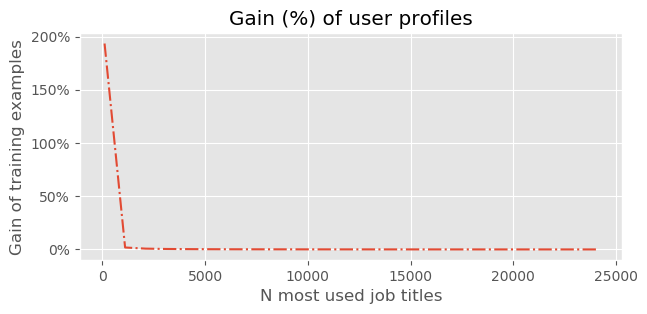

In [117]:
x_gains = x[1:]
gains = [(100*(curr - prev))/prev for prev, curr in zip(y[:-1], y[1:])]

plt.rcParams['figure.figsize'] = 7, 3
plt.rcParams['figure.dpi'] = 100

plt.plot(x_gains[:250:10], gains[:250:10], '-.', alpha=1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()]) 
plt.title("Gain (%) of user profiles")
plt.xlabel("N most used job titles")
plt.ylabel("Gain of training examples")

In [100]:
x, y = compute_gain(df, reduced_freqs, col='reduced')

Text(0,0.5,'Gain of training examples')

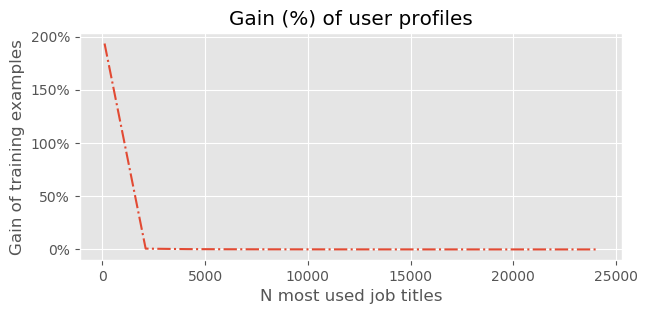

In [127]:
x_gains = x[1:]
gains = [(100*(curr - prev))/prev for prev, curr in zip(y[:-1], y[1:])]

plt.rcParams['figure.figsize'] = 7, 3
plt.rcParams['figure.dpi'] = 100
n = 250
step = 20
plt.plot(x_gains[:n:step], gains[:n:step], '-.', alpha=1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()]) 
plt.title("Gain (%) of user profiles")
plt.xlabel("N most used job titles")
plt.ylabel("Gain of training examples")